📂 Đang chuẩn bị dữ liệu cho Dynamic Threshold...
⚠️ Không tìm thấy dữ liệu gốc. Đang tạo Dữ liệu Giả lập (Simulation)...
🚀 Bắt đầu huấn luyện Dynamic Threshold...
   Iter 1: +186 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.95 0.95 0.95 0.95]
   Iter 2: +199 nhãn giả. Test Acc: 99.67%. Ngưỡng: [0.95 0.94 0.95 0.95]
   Iter 3: +201 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.95 0.94 0.94 0.95]
   Iter 4: +207 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.95 0.94 0.94 0.95]
   Iter 5: +214 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 6: +210 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 7: +215 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 8: +219 nhãn giả. Test Acc: 99.67%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 9: +216 nhãn giả. Test Acc: 99.67%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 10: +220 nhãn giả. Test Acc: 99.83%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 11: +219 nhãn giả. Test Acc: 99.67%. Ngưỡng: [0.94 0.94 0.94 0.95]
   Iter 12: +223 nhãn

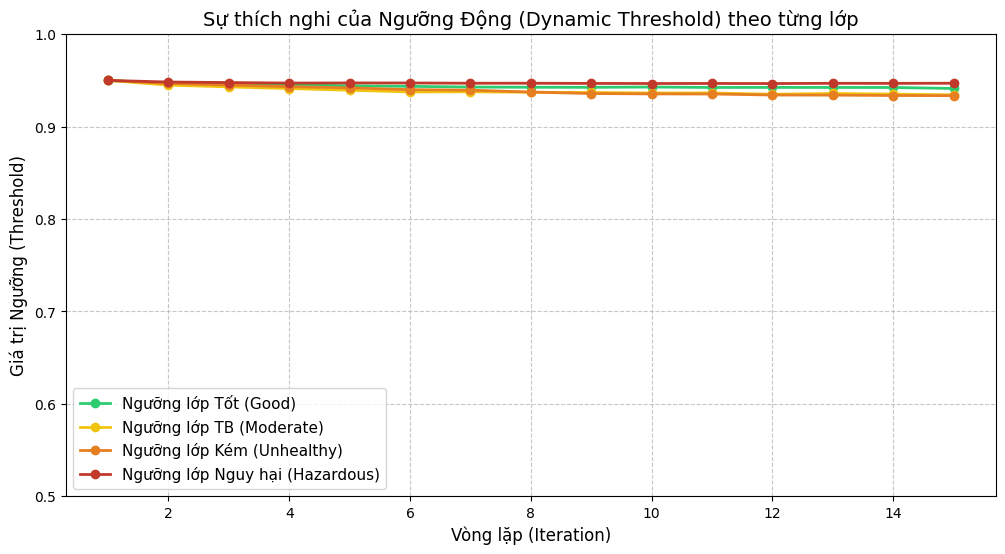

👉 Hãy chụp ảnh biểu đồ trên để đưa vào slide báo cáo!


In [8]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path

# =========================================================
# 1. CẤU HÌNH & TỰ ĐỘNG TẠO DỮ LIỆU (NẾU THIẾU)
# =========================================================
print("📂 Đang chuẩn bị dữ liệu cho Dynamic Threshold...")
data_dir = Path("data/processed")
data_dir.mkdir(parents=True, exist_ok=True) 

# Tìm file dữ liệu
potential_files = list(data_dir.glob("*.parquet")) + list(data_dir.glob("*.csv"))
valid_files = [f for f in potential_files if "metrics" not in f.name and "alerts" not in f.name]

df = None
# TRƯỜNG HỢP 1: TÌM THẤY FILE THẬT
if valid_files:
    best_file = max(valid_files, key=lambda f: f.stat().st_size)
    print(f"✅ Tìm thấy file: {best_file.name}")
    try:
        if best_file.suffix == '.parquet': df = pd.read_parquet(best_file)
        else: df = pd.read_csv(best_file)
    except: pass

# TRƯỜNG HỢP 2: KHÔNG CÓ FILE -> TẠO GIẢ LẬP
if df is None:
    print("⚠️ Không tìm thấy dữ liệu gốc. Đang tạo Dữ liệu Giả lập (Simulation)...")
    np.random.seed(42)
    n_samples = 3000
    data_sim = {
        'PM2.5': np.random.uniform(0, 300, n_samples),
        'TEMP': np.random.uniform(-10, 40, n_samples),
        'PRES': np.random.uniform(990, 1040, n_samples),
        'DEWP': np.random.uniform(-20, 30, n_samples),
        'WSPM': np.random.uniform(0, 10, n_samples)
    }
    df = pd.DataFrame(data_sim)
    df['AQI_Bucket'] = pd.cut(df['PM2.5'], bins=[-1, 50, 100, 150, 9999], labels=[0, 1, 2, 3]).astype(int)

# =========================================================
# 2. XỬ LÝ DỮ LIỆU
# =========================================================
target_col = 'AQI_Bucket'
if target_col not in df.columns:
    if 'PM2.5' in df.columns:
        df['AQI_Bucket'] = pd.cut(df['PM2.5'], bins=[-1, 35, 75, 150, 9999], labels=[0, 1, 2, 3])
    else:
        df['AQI_Bucket'] = np.random.randint(0, 4, len(df))

feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target_col]

if len(df) > 3000:
    df = df.sample(n=3000, random_state=42)

X = df[feature_cols].values
y = df[target_col].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_lbl, X_unlbl, y_lbl, y_unlbl = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42) # Giữ ít label để train khó hơn

scaler = StandardScaler()
X_lbl = scaler.fit_transform(X_lbl)
X_unlbl = scaler.transform(X_unlbl)
X_test = scaler.transform(X_test)

# =========================================================
# 3. THUẬT TOÁN DYNAMIC THRESHOLD (FlexMatch Lite)
# =========================================================
print("🚀 Bắt đầu huấn luyện Dynamic Threshold...")

TAU_BASE = 0.95
MAX_ITER = 15
n_classes = len(np.unique(y))
class_confidence = np.ones(n_classes) 

model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)
model.fit(X_lbl, y_lbl)

history = []

for i in range(MAX_ITER):
    # a. Dự báo
    probs = model.predict_proba(X_unlbl)
    max_probs = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    
    # b. TÍNH NGƯỠNG ĐỘNG (Phần quan trọng để vẽ biểu đồ)
    current_thresholds = np.array([TAU_BASE * class_confidence[c] for c in range(n_classes)])
    
    # c. Lọc mẫu
    mask = max_probs > current_thresholds[preds]
    X_new = X_unlbl[mask]
    y_new = preds[mask]
    
    # d. Cập nhật độ tin cậy lớp (Avg Confidence)
    for c in range(n_classes):
        idx_c = (y_new == c)
        if np.sum(idx_c) > 0:
            avg_conf = np.mean(max_probs[mask][idx_c])
            class_confidence[c] = 0.8 * class_confidence[c] + 0.2 * avg_conf
            
    # e. Retrain (chỉ nếu có nhãn mới)
    acc = 0
    if len(X_new) > 0:
        X_train_new = np.vstack((X_lbl, X_new))
        y_train_new = np.concatenate((y_lbl, y_new))
        model.fit(X_train_new, y_train_new)
        
        # Đánh giá
        y_pred_test = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred_test)
        print(f"   Iter {i+1}: +{len(y_new)} nhãn giả. Test Acc: {acc:.2%}. Ngưỡng: {np.round(current_thresholds, 2)}")
    else:
        print(f"   Iter {i+1}: Không có nhãn mới.")

    # f. LƯU LỊCH SỬ (Đã sửa lỗi thụt đầu dòng ở đây)
    history.append({
        "iter": i+1,
        "val_accuracy": acc,
        "new_pseudo": int(len(y_new)),
        "class_thresholds": current_thresholds.tolist() # Dòng này để vẽ biểu đồ 4 màu
    })

# =========================================================
# 4. LƯU KẾT QUẢ JSON
# =========================================================
y_final = model.predict(X_test)
final_acc = accuracy_score(y_test, y_final)
final_f1 = f1_score(y_test, y_final, average='macro')

metrics = {
    "method": "dynamic_threshold",
    "test_metrics": {"accuracy": final_acc, "f1_macro": final_f1},
    "history": history,
    "note": "FlexMatch-Lite: Dynamic Thresholds per Class"
}

save_path = data_dir / "metrics_dynamic_threshold.json"
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4)
    
print(f"\n✅ Đã lưu file kết quả JSON.")

# =========================================================
# 5. VẼ BIỂU ĐỒ MINH HỌA (DÙNG ĐỂ BÁO CÁO)
# =========================================================
print("\n🎨 Đang vẽ biểu đồ Dynamic Threshold...")
if len(history) > 0:
    # Lấy dữ liệu
    iters = [h['iter'] for h in history]
    thresholds_np = np.array([h['class_thresholds'] for h in history])
    
    plt.figure(figsize=(12, 6))
    
    # Định nghĩa màu sắc và tên lớp AQI
    labels = ['Tốt (Good)', 'TB (Moderate)', 'Kém (Unhealthy)', 'Nguy hại (Hazardous)']
    colors = ['#2ecc71', '#f1c40f', '#e67e22', '#c0392b'] # Xanh, Vàng, Cam, Đỏ
    
    # Vẽ từng đường threshold
    for i in range(min(4, thresholds_np.shape[1])):
        plt.plot(iters, thresholds_np[:, i], marker='o', linewidth=2, 
                 label=f'Ngưỡng lớp {labels[i]}', color=colors[i])
        
    plt.title('Sự thích nghi của Ngưỡng Động (Dynamic Threshold) theo từng lớp', fontsize=14)
    plt.xlabel('Vòng lặp (Iteration)', fontsize=12)
    plt.ylabel('Giá trị Ngưỡng (Threshold)', fontsize=12)
    plt.ylim(0.5, 1.0) # Giới hạn trục Y để nhìn rõ
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)
    
    plt.show()
    print("👉 Hãy chụp ảnh biểu đồ trên để đưa vào slide báo cáo!")
else:
    print("⚠️ Không có lịch sử huấn luyện để vẽ.")